In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from skimage.feature import hog
from skimage.color import rgb2gray

In [2]:
# ========== Feature Extractor (Color Histogram) ==========
def extract_features(image, bins=32, resize_dim=(64, 64)):
    image = image.resize(resize_dim).convert('RGB') # Ensures that all images are RGB
    image_np = np.array(image)
    hist_r = np.histogram(image_np[:, :, 0], bins=bins, range=(0, 256))[0]
    hist_g = np.histogram(image_np[:, :, 1], bins=bins, range=(0, 256))[0]
    hist_b = np.histogram(image_np[:, :, 2], bins=bins, range=(0, 256))[0]
    hist = np.concatenate([hist_r, hist_g, hist_b])
    return hist / np.sum(hist)

In [ ]:
def extract_hog_features(image, resize_dim=(64, 64), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    image = image.resize(resize_dim).convert('RGB')
    gray = rgb2gray(np.array(image))
    features = hog(gray, orientations=orientations,
                   pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block,
                   block_norm='L2-Hys')
    return features



def extract_combined_features(image):
    hog_feat = extract_hog_features(image)
    hist_feat = extract_features(image)
    return np.concatenate([hog_feat, hist_feat])

In [ ]:
# Parameters
image_size = (64, 64)  # Resize all images to 64x64
valid_exts = ('.jpg', '.jpeg', '.png')

# Function to load images from a given folder
def load_dataset(root_dir, extractor_fn):
    X = []
    y = []
    class_names = sorted(os.listdir(root_dir))
    for label in class_names:
        label_path = os.path.join(root_dir, label)
        if not os.path.isdir(label_path):
            continue
        for fname in os.listdir(label_path):
            if fname.lower().endswith(valid_exts):
                try:
                    img_path = os.path.join(label_path, fname)
                    img = Image.open(img_path).convert('RGB')
                    if extractor_fn == None:
                        img = img.resize(image_size)
                        img_array = np.array(img).flatten()  # Flatten to 1D vector (64*64*3)
                        X.append(img_array)
                        y.append(label)
                    else:
                        features = extractor_fn(img)
                        X.append(features)
                        y.append(label)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    return np.array(X), np.array(y)

# Load training and testing data
print("=== Load data ===")
func_name = None #extract_features  #extract_combined_features #None
X_train, y_train = load_dataset("Training", func_name)
X_test, y_test = load_dataset("Test", func_name)

# Encode labels (e.g., 'library' -> 0, etc.)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Shuffle and standardize
X_train, y_train_enc = shuffle(X_train, y_train_enc, random_state=42)
X_test, y_test_enc = shuffle(X_test, y_test_enc, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Classes: {le.classes_}")

=== Load data ===
Train shape: (15000, 12288), Test shape: (300, 12288)
Classes: ['library-indoor' 'museum-indoor' 'shopping_mall-indoor']


In [44]:
# ========== Semi-Supervised Tree ==========
# def semi_supervised_dt(X, y_true, test_X, test_y, n_iter=5, confidence_thresh=0.9):
n_iter=10
confidence_thresh=0.85
np.random.seed(420)
total_idx = np.arange(len(X_train))
labeled_idx = np.random.choice(total_idx, size=int(0.2 * len(X_train)), replace=False)
unlabeled_idx = np.setdiff1d(total_idx, labeled_idx)

y_pseudo = y_train_enc.copy()
clf = DecisionTreeClassifier(criterion='gini', 
                             max_depth=10, 
                             min_samples_split=5, 
                             min_samples_leaf=5,
                             random_state=42, 
                             max_leaf_nodes=None)

for i in range(n_iter):
    clf.fit(X_train[labeled_idx], y_pseudo[labeled_idx])
    probs = clf.predict_proba(X_train[unlabeled_idx])
    preds = np.argmax(probs, axis=1)
    max_conf = np.max(probs, axis=1)
    confident_idx = np.where(max_conf >= confidence_thresh)[0]
    if len(confident_idx) == 0:
        break
    confident_unlabeled = unlabeled_idx[confident_idx]
    y_pseudo[confident_unlabeled] = preds[confident_idx]
    labeled_idx = np.concatenate([labeled_idx, confident_unlabeled])
    unlabeled_idx = np.setdiff1d(unlabeled_idx, confident_unlabeled)
    # if unlabeled_idx.size==0:
    #     break

# clf.fit(X_train[labeled_idx], y_pseudo[labeled_idx])
preds = clf.predict(X_test)
print("\n--- Semi-Supervised Decision Tree Report ---")
print(classification_report(y_test_enc, preds))
print(confusion_matrix(y_test_enc, preds))
# return clf

# ---- Semi-Supervised DT ----
# semi_supervised_dt(X_train, y_train_enc, X_test, y_test_enc)


--- Semi-Supervised Decision Tree Report ---
              precision    recall  f1-score   support

           0       0.41      0.44      0.43       100
           1       0.47      0.42      0.44       100
           2       0.46      0.47      0.46       100

    accuracy                           0.44       300
   macro avg       0.44      0.44      0.44       300
weighted avg       0.44      0.44      0.44       300

[[44 25 31]
 [33 42 25]
 [30 23 47]]


In [43]:
clf.predict_proba(X_test)

array([[0.4469697 , 0.14393939, 0.40909091],
       [0.0295203 , 0.05535055, 0.91512915],
       [0.02139037, 0.93582888, 0.04278075],
       [0.07692308, 0.03846154, 0.88461538],
       [0.26909091, 0.24      , 0.49090909],
       [0.95454545, 0.        , 0.04545455],
       [0.01886792, 0.00628931, 0.97484277],
       [0.00775194, 0.05426357, 0.9379845 ],
       [0.54022989, 0.19770115, 0.26206897],
       [0.18181818, 0.72727273, 0.09090909],
       [0.41573034, 0.3258427 , 0.25842697],
       [0.0295203 , 0.05535055, 0.91512915],
       [0.86904762, 0.05952381, 0.07142857],
       [0.8970297 , 0.07623762, 0.02673267],
       [0.8970297 , 0.07623762, 0.02673267],
       [0.00847458, 0.99152542, 0.        ],
       [0.01851852, 0.22222222, 0.75925926],
       [0.26909091, 0.24      , 0.49090909],
       [1.        , 0.        , 0.        ],
       [0.00456621, 0.9847793 , 0.01065449],
       [0.01886792, 0.00628931, 0.97484277],
       [0.41573034, 0.3258427 , 0.25842697],
       [0.

[Text(0.4345452724358974, 0.9444444444444444, 'x[1451] <= -0.151\ngini = 0.664\nsamples = 11518\nvalue = [4260.0, 3401.0, 3857.0]'),
 Text(0.13892227564102563, 0.8333333333333334, 'x[555] <= -1.309\ngini = 0.607\nsamples = 5709\nvalue = [2792, 2081, 836]'),
 Text(0.2867337740384615, 0.8888888888888888, 'True  '),
 Text(0.04366987179487179, 0.7222222222222222, 'x[1927] <= -0.358\ngini = 0.491\nsamples = 1113\nvalue = [207, 751, 155]'),
 Text(0.01842948717948718, 0.6111111111111112, 'x[9510] <= -1.56\ngini = 0.351\nsamples = 885\nvalue = [134, 698, 53]'),
 Text(0.00641025641025641, 0.5, 'x[2770] <= 1.318\ngini = 0.034\nsamples = 57\nvalue = [56, 1, 0]'),
 Text(0.003205128205128205, 0.3888888888888889, 'gini = 0.0\nsamples = 52\nvalue = [52, 0, 0]'),
 Text(0.009615384615384616, 0.3888888888888889, 'gini = 0.32\nsamples = 5\nvalue = [4, 1, 0]'),
 Text(0.030448717948717948, 0.5, 'x[4789] <= 0.941\ngini = 0.278\nsamples = 828\nvalue = [78.0, 697.0, 53.0]'),
 Text(0.016025641025641024, 0.3888

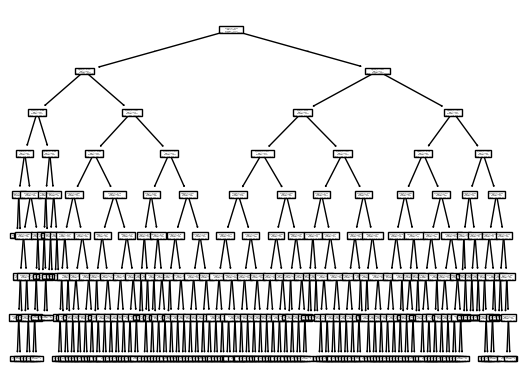

In [39]:
from sklearn import tree
tree.plot_tree(clf)

In [45]:
preds_train = clf.predict(X_train)
print("\n--- Semi-Supervised Decision Tree Report ---")
print(classification_report(y_train_enc, preds_train))
print(confusion_matrix(y_train_enc, preds_train))


--- Semi-Supervised Decision Tree Report ---
              precision    recall  f1-score   support

           0       0.47      0.53      0.50      5000
           1       0.53      0.46      0.49      5000
           2       0.52      0.51      0.51      5000

    accuracy                           0.50     15000
   macro avg       0.50      0.50      0.50     15000
weighted avg       0.50      0.50      0.50     15000

[[2662 1106 1232]
 [1569 2324 1107]
 [1470  988 2542]]


In [ ]:
# ========== Feature Extractors ==========
def extract_hog_features(image, resize_dim=(64, 64), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    image = image.resize(resize_dim).convert('RGB')
    gray = rgb2gray(np.array(image))
    features = hog(gray, orientations=orientations,
                   pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block,
                   block_norm='L2-Hys')
    return features

def extract_color_histogram(image, bins=32, resize_dim=(64, 64)):
    image = image.resize(resize_dim).convert('RGB')
    image_np = np.array(image)
    hist_r = np.histogram(image_np[:, :, 0], bins=bins, range=(0, 256))[0]
    hist_g = np.histogram(image_np[:, :, 1], bins=bins, range=(0, 256))[0]
    hist_b = np.histogram(image_np[:, :, 2], bins=bins, range=(0, 256))[0]
    hist = np.concatenate([hist_r, hist_g, hist_b])
    return hist / np.sum(hist)

def extract_combined_features(image):
    hog_feat = extract_hog_features(image)
    hist_feat = extract_color_histogram(image)
    return np.concatenate([hog_feat, hist_feat])

# Only use color histogram now
def extract_features(image):
    return extract_color_histogram(image)

In [ ]:
# --- Color Histogram Only ---
def extract_color_histogram(image, bins=32, resize_dim=(64, 64)):
    image = image.resize(resize_dim).convert('RGB')
    image_np = np.array(image)
    hist_r = np.histogram(image_np[:, :, 0], bins=bins, range=(0, 256))[0]
    hist_g = np.histogram(image_np[:, :, 1], bins=bins, range=(0, 256))[0]
    hist_b = np.histogram(image_np[:, :, 2], bins=bins, range=(0, 256))[0]
    hist = np.concatenate([hist_r, hist_g, hist_b])
    return hist / np.sum(hist)

